# 制約付きLQR

参考：
* [Reinforcement Learning: Theory and Algorithms](https://rltheorybook.github.io/)
* [Safely Learning to Control the Constrained Linear Quadratic Regulator](https://arxiv.org/abs/1809.10121)

もっと良い資料探そう．TODO:

[前回](RL_LQR_as_SDP.ipynb)，LQRが半正定値計画問題として解けることを見ました．
LQRの双対性をよく見ると，これはOccupancy measureを使ったMDPの線形計画問題とよく似ています（[RL_as_LP.ipynb](RL_as_LP.ipynb)参照）．

つまり，自然な形で他の制約を導入することができます．

## 制約付きLQR

もとのLQRでは次の問題を解くことを考えていました．
$$
\begin{array}{ll}
\operatorname{minimize} & \mathbb{E}_\pi\left[\sum_{t=0}^H c_t\left(x_t, u_t\right)\right] \\
\text { such that } & x_{t+1}=x_{t+1}=A_t x_t+B_t u_t+w_t\; t=0, \ldots, H
\end{array}
$$

ここにさらに次のような多面体による制約を考えます：

$$
\mathcal{X}:=\left\{x: F_x x \leq b_x\right\}
$$

合体して，次の問題を解きます：

$$
\begin{array}{ll}
\operatorname{minimize} & \lim_{H\to \infty}\frac{1}{H}\mathbb{E}_\pi\left[\sum_{t=0}^H c_t\left(x_t, u_t\right)\right] \\
\text { such that } & x_{t+1}=A_t x_t+B_t u_t+w_t\; t=0, \ldots, H\\
& F_x x_t \leq b_x
\end{array}
$$


これを双対形式で表しましょう．つまり，

$$
\begin{array}{ll}
\operatorname{minimize} & \operatorname{Trace}\left(\Sigma \cdot\left[\begin{array}{ll}
Q & 0 \\
0 & R
\end{array}\right]\right) \\
\text { subject to } & \Sigma_{x x}=\left(\begin{array}{ll}
A & B
\end{array}\right) \Sigma(A B)^{\top}+\sigma^2 I, \quad \Sigma \succeq 0,
\end{array}
$$

and

$$
\Sigma=\left[\begin{array}{ll}
\Sigma_{x x} & \Sigma_{x u} \\
\Sigma_{u x} & \Sigma_{u u}
\end{array}\right]
$$

に対して多面体の制約を追加します．
初期状態として$x_0$を固定しましょう．このとき，
共分散行列を使えば$x_\infty$は$\Sigma_{x x}x_0$として評価できるので（MDPにおける$\mu^\top d^\pi$と同じ？），制約として

$$
F_x \Sigma_{x x} x_0 \leq b_x
$$

を追加すれば良いことになります．

In [217]:
import numpy as np
from typing import NamedTuple


# 無限ホライゾン用です
class MDP(NamedTuple):
    d: int  # 状態の次元
    k: int  # 入力の次元
    A: np.array  # 遷移行列
    B: np.array  # 遷移行列
    Q: np.array  # コスト行列
    R: np.array  # コスト行列
    sigma: float  # ノイズの大きさ
    Fx: np.array  # 状態制約用の行列
    bx: float  # 状態制約の閾値


d = 5
k = 2
sigma = 0.01
A = np.random.rand(d, d) * 0.3
B = np.random.rand(d, k) * 0.1
Q = np.random.randn(d, d)
Q = Q @ Q.T

R = np.random.randn(k, k)
R = R @ R.T

Fx = np.random.rand(d)
bx = 0.01

mdp = MDP(d, k, A, B, Q, R, sigma, Fx, bx)

In [218]:
# 双対問題を解きます

import cvxpy as cp

Sxx = cp.Variable((d, d), symmetric=True)
Sxu = cp.Variable((d, k))
Suu = cp.Variable((k, k), symmetric=True)

S = cp.bmat([
    [Sxx, Sxu],
    [Sxu.T, Suu]
])

AB = np.block([mdp.A, mdp.B])
QR = np.block([
    [mdp.Q, np.zeros((d, k))],
    [np.zeros((k, d)), mdp.R],
])

constraints = [Sxx == AB @ S @ AB.T + mdp.sigma ** 2 * np.eye(d), S >> 0]

prob = cp.Problem(cp.Minimize(cp.trace(S @ QR)), constraints)
prob.solve()

S = S.value
Sux = Sxu.value.T
Sxx = Sxx.value

In [219]:
import matplotlib.pyplot as plt

# 制御器をダイナミクス上で走らせて得られる価値を観察します
gain = - Sux @ np.linalg.inv(Sxx)
x0 = np.random.randn(mdp.d)

Vs = []
vios = []
for seed in range(10):
    x = x0.copy()
    V = []
    vio = []
    for h in range(100):
        u = - gain @ x

        # コストを計算します
        cost = x.T @ mdp.Q @ x + u.T @ mdp.R @ u
        V.append(cost)

        # 制約違反を計算します
        vio.append(min(mdp.Fx @ x - mdp.bx, 0))

        # ダイナミクスを進めます
        noise = np.random.randn() * mdp.sigma
        x = mdp.A @ x + mdp.B @ u + noise

    cost = x.T @ mdp.Q @ x
    V.append(cost)

    V = np.array(V[::-1])
    V = np.cumsum(V)[::-1]
    Vs.append(V)
    vios.append(vio)

mean_V = np.array(Vs).mean(axis=0)
mean_vio = np.array(vios).mean(axis=0)
print(f"最後の方の価値：{mean_V[-1]}")

最後の方の価値：0.002191414729519979


In [220]:
# 制約付きの双対問題を解きます

import cvxpy as cp

Sxx = cp.Variable((d, d), symmetric=True)
Sxu = cp.Variable((d, k))
Suu = cp.Variable((k, k), symmetric=True)

S = cp.bmat([
    [Sxx, Sxu],
    [Sxu.T, Suu]
])

AB = np.block([mdp.A, mdp.B])
QR = np.block([
    [mdp.Q, np.zeros((d, k))],
    [np.zeros((k, d)), mdp.R],
])
constraints = [Sxx == AB @ S @ AB.T + mdp.sigma ** 2 * np.eye(d), S >> 0]

# 追加の制約です
constraints += [mdp.Fx @ Sxx @ x0 <= mdp.bx]

prob = cp.Problem(cp.Minimize(cp.trace(S @ QR)), constraints)
prob.solve()

S = S.value
Sux = Sxu.value.T
Sxx = Sxx.value

In [221]:
import matplotlib.pyplot as plt

# 制御器をダイナミクス上で走らせて得られる価値を観察します
gain = - Sux @ np.linalg.inv(Sxx)
cVs = []
cvios = []
for seed in range(10):
    x = x0.copy()
    V = []
    vio = []
    for h in range(100):
        u = - gain @ x

        # コストを計算します
        cost = x.T @ mdp.Q @ x + u.T @ mdp.R @ u
        V.append(cost)

        # 制約違反を計算します
        vio.append(min(mdp.Fx @ x - mdp.bx, 0))

        # ダイナミクスを進めます
        noise = np.random.randn() * mdp.sigma
        x = mdp.A @ x + mdp.B @ u + noise

    cost = x.T @ mdp.Q @ x
    V.append(cost)

    V = np.array(V[::-1])
    V = np.cumsum(V)[::-1]
    cVs.append(V)
    cvios.append(vio)

mean_cV = np.array(cVs).mean(axis=0)
mean_cvio = np.array(cvios).mean(axis=0)
print(f"最後の方の価値：{mean_cV[-1]}")

最後の方の価値：0.001772470065882734


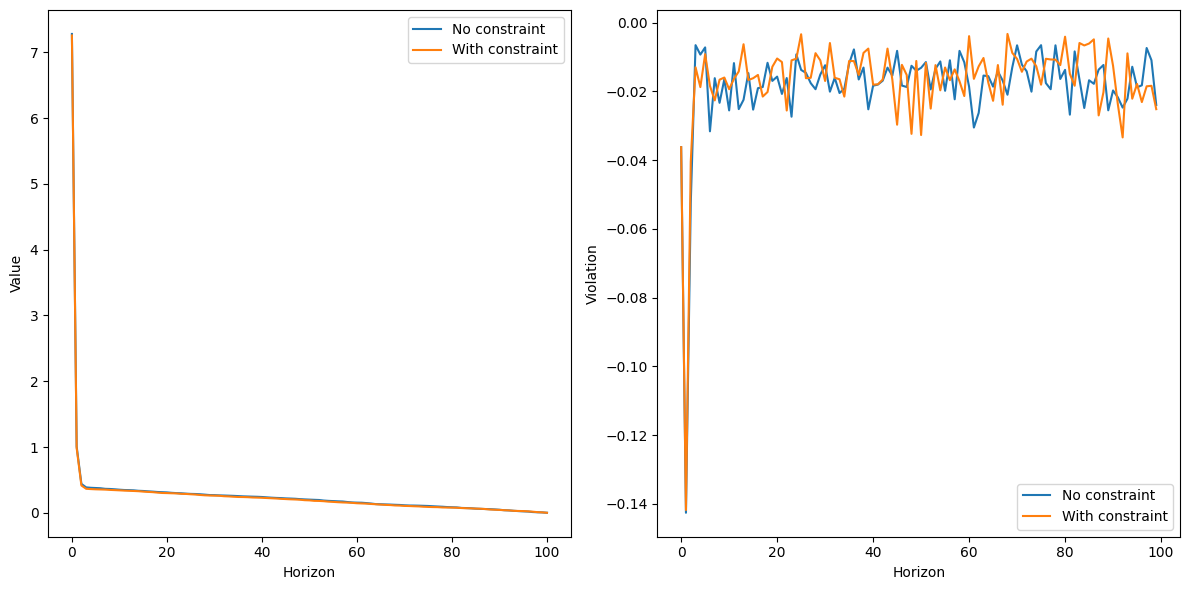

In [222]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mean_V, label=f"No constraint")
plt.plot(mean_cV, label=f"With constraint")
plt.xlabel("Horizon")
plt.ylabel("Value")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_vio, label=f"No constraint")
plt.plot(mean_cvio, label=f"With constraint")
plt.xlabel("Horizon")
plt.ylabel("Violation")
plt.legend()

plt.tight_layout()